In [1]:
import re
import yaml
import json
import demjson
import pandas as pd
import numpy as np
from numpy import loadtxt
import tensorflow as tf
from src.datapipeline_6estate import DataPipeline, Model
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from langdetect import detect
import transformers

%load_ext autoreload
%autoreload 2

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500)

C:\Users\kewen\Anaconda3\envs\x-train\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kewen\Anaconda3\envs\x-train\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\kewen\Anaconda3\envs\x-train\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [125]:
# load in the data
train = pd.DataFrame([demjson.decode(line) for line in open('data/train.json', 'r')])
val = pd.DataFrame([demjson.decode(line) for line in open('data/dev.json', 'r')])
test = pd.DataFrame([demjson.decode(line) for line in open('data/test.json', 'r')])

display("train:", train.head())
display("val:", val.head())
display("test:", test.head())

'train:'

,label,sentence
0,1,"it's all stitched together with energy , intelligence and verve , enhanced by a surplus of vintage archive footage ."
1,0,"because of an unnecessary and clumsy last scene , 'swimfan' left me with a very bad feeling ."
2,0,the stories here suffer from the chosen format .
3,1,it turns out to be smarter and more diabolical than you could have guessed at the beginning .
4,0,"all of the elements are in place for a great film noir , but director george hickenlooper's approach to the material is too upbeat ."


'val:'

,label,sentence
0,0,the colorful masseur wastes its time on mood rather than riding with the inherent absurdity of ganesh's rise up the social ladder .
1,0,"a timid , soggy near miss ."
2,0,going to the website may be just as fun ( and scary ) as going to the film .
3,1,"nervy and sensitive , it taps into genuine artistic befuddlement , and at the same time presents a scathing indictment of what drives hollywood ."
4,1,"it may not be a huge cut of above the rest , but i enjoyed barbershop . it's a funny little movie with clever dialogue and likeable characters ."


'test:'

,label,sentence
0,0,"the direction , by george hickenlooper , has no snap to it , no wiseacre crackle or hard-bitten cynicism ."
1,0,barry sonnenfeld owes frank the pug big time
2,1,"if this movie were a book , it would be a page-turner , you can't wait to see what happens next ."
3,0,"[garbus] discards the potential for pathological study , exhuming instead , the skewed melodrama of the circumstantial situation ."
4,1,not too far below the gloss you can still feel director denis villeneuve's beating heart and the fondness he has for his characters .


# <font color="green"> EDA

In [5]:
train.shape

(8636, 2)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8636 entries, 0 to 8635
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     8636 non-null   int64 
 1   sentence  8636 non-null   object
dtypes: int64(1), object(1)
memory usage: 135.1+ KB


In [7]:
train.label.value_counts()

1    4318
0    4318
Name: label, dtype: int64

In [13]:
# the class labels are quite balanced

In [15]:
3e-5

3e-05

In [9]:
train.sentence.apply(lambda x: len(x)).describe()

count    8636.000000
mean      115.285665
std        51.051265
min         5.000000
25%        77.000000
50%       112.000000
75%       150.000000
max       268.000000
Name: sentence, dtype: float64

In [10]:
# most of the sentences have length around 110 words, which is not so length, so we can just apply truncate when training models

In [11]:
val.shape

(960, 2)

In [12]:
test.shape

(1066, 2)

In [13]:
val.label.value_counts()

1    480
0    480
Name: label, dtype: int64

In [14]:
test.label.value_counts()

1    533
0    533
Name: label, dtype: int64

In [15]:
# the data was nicely prepared, so we don't have to consider imbalance class problem, accuracy can be used for evaluation

In [16]:
train.sentence.duplicated().any(axis=0)

False

In [17]:
test.sentence.duplicated().any(axis=0)

False

In [18]:
val.sentence.duplicated().any(axis=0)

False

In [19]:
# seems no duplicates in terms of sentences

In [20]:
train.isnull().any(axis=0)

label       False
sentence    False
dtype: bool

In [21]:
test.isnull().any(axis=0)

label       False
sentence    False
dtype: bool

In [22]:
val.isnull().any(axis=0)

label       False
sentence    False
dtype: bool

In [23]:
# no missing value found also

# <font color="green"> Data Cleaning

In [25]:
# random choose some samples to examine
train.sample(20)

,label,sentence
3089,1,"there is nothing outstanding about this film , but it is good enough and will likely be appreciated most by sailors and folks who know their way around a submarine ."
5845,1,"while not quite "" shrek "" or monsters , inc . "" , it's not too bad . it's worth taking the kids to ."
5638,0,it wouldn't be my preferred way of spending 100 minutes or $7 . 00 .
3796,1,"though few will argue that it ranks with the best of herzog's works , invincible shows he's back in form , with an astoundingly rich film ."
8025,0,"with very little to add beyond the dark visions already relayed by superb recent predecessors like swimming with sharks and the player , this latest skewering . . . may put off insiders and outsiders alike ."
7800,0,"a mawkish , implausible platonic romance that makes chaplin's city lights seem dispassionate by comparison ."
5912,1,"it's a much more emotional journey than what shyamalan has given us in his past two movies , and gibson , stepping in for bruce willis , is the perfect actor to take us on the trip ."
1624,0,"some movies were made for the big screen , some for the small screen , and some , like ballistic : ecks vs . sever , were made for the palm screen ."
7419,1,it is refreshingly undogmatic about its characters .
4109,0,"after the setup , the air leaks out of the movie , flattening its momentum with about an hour to go ."


In [26]:
# remove non-English examples

In [38]:
non_English = train[train.sentence.apply(lambda x: detect(x)) != "en"]

In [41]:
# not all the results are non-English, so we need to manually filter it
non_English

,label,sentence
102,1,'interesante y disfrutable trabajo gracias a que prescinde del clsico elemento estadounidense patriotero y manipulador . '
167,0,a bravura exercise in emptiness .
181,0,"no dia em que aceitou dirigir esta continuao , harold ramis deve ter sado da cama com o p esquerdo . e aqueles que decidiram assistir a este filme tambm ."
213,1,touch !
253,0,just a bloody mess .
301,0,"'es en verdad una pena que mandoki est realizando cintas tan malas desde hace algn tiempo , pues talento tiene , pero quin sabe dnde lo tiene escondido . '"
373,0,cinematic poo .
432,1,ahhhh . . . revenge is sweet !
454,1,a true pleasure .
521,1,ns gosta muito de as duas torres .


In [29]:
# need visually check which one is really non-English

In [42]:
# prepare the drop list based on eyeballing checks
drop_list = [102, 181, 301, 521, 587, 694, 883, 1186, 1273, 1462, 1682, 2025, 2367, 2578, 3064, 3349, 3579, 3820, 3822, 3892, 3894, 3896, 4145, 4195, 4260, 4326, 4372, 4377, 4646, 4750, 4796, 4803, 4916, 4931, 5496, 5686, 5973, 6112, 6178, 6245, 6354, 6414, 6449, 6636, 6764, 6944, 7334, 7432, 7498, 7842, 8388]

In [44]:
# now we are very sure those 51 examples are not in English 
train.iloc[drop_list, :]

,label,sentence
102,1,'interesante y disfrutable trabajo gracias a que prescinde del clsico elemento estadounidense patriotero y manipulador . '
181,0,"no dia em que aceitou dirigir esta continuao , harold ramis deve ter sado da cama com o p esquerdo . e aqueles que decidiram assistir a este filme tambm ."
301,0,"'es en verdad una pena que mandoki est realizando cintas tan malas desde hace algn tiempo , pues talento tiene , pero quin sabe dnde lo tiene escondido . '"
521,1,ns gosta muito de as duas torres .
587,1,"el ttulo no engaa : la pelcula narra una historia donde una mujer enfrentar cierta realidad , y donde el sexo es . . ."
694,1,"uma pena que , mais tarde , o prprio filme abandone o tom de pardia e passe a utilizar os mesmos clichs que havia satirizado ."
883,1,"apesar de seus graves problemas , o filme consegue entreter ."
1186,1,"en s mismo el rey len es un espectculo digno de contemplarse en cine , dvd o en su soberbio montaje teatral ; pero el hacerlo en la pantalla imax es una experiencia colosal ."
1273,1,"es una de esas pelculas de las que uno sale reconfortado , agradecido , genuinamente sorprendido ."
1462,1,"chicago pode at ser um filme divertido e cativante ( como ) , mas acaba representando um passo que vai na direo contrria evoluo dos musicais ."


In [47]:
len(drop_list)

51

In [ ]:
# sanity check
8585 + 51

In [46]:
# update train set
train = train.drop(drop_list, axis=0)

In [48]:
train.shape

(8585, 2)

In [49]:
def expand_contractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
train.loc[:, "sentence"] = train.sentence.apply(lambda x: expand_contractions(x))

In [126]:
# apply data pipeline
dp = DataPipeline()

train = dp.transform_data("data/train.json")
val = dp.transform_data("data/dev.json")
test = dp.transform_data("data/test.json")

INFO:6estates:Datapipeline is initiated
INFO:6estates:performed dropping missing values
INFO:6estates:performed dropping duplicates
INFO:6estates:finished transforming data
INFO:6estates:performed dropping missing values
INFO:6estates:performed dropping duplicates
INFO:6estates:finished transforming data
INFO:6estates:performed dropping missing values
INFO:6estates:performed dropping duplicates
INFO:6estates:finished transforming data


# <font color="green"> Try TF-IDF Model As Benchmark

In [130]:
train_bow = train.copy()
test_bow = test.copy()
val_bow = val.copy()

In [11]:
from nltk.stem import WordNetLemmatizer
import string
import nltk
from nltk.tokenize import ToktokTokenizer
nltk.download('wordnet')
from nltk.corpus import wordnet
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kewen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [97]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [98]:
lemmatizer = WordNetLemmatizer()

In [99]:
def Lemmatization(lemmatizer, sentence):
    lemma_sentence=[]
    for word in sentence:
        lemma_sentence.append(lemmatizer.lemmatize(word, pos=get_wordnet_pos(word))) # need long time to run
        #lemma_sentence.append(lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [116]:
def tokenize(text):
            
    # remove special characters
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    processed_text = re.sub(pat, '', text)
    
    # remove digits
    pattern = '[0-9]'
    processed_text = re.sub(pattern, '', processed_text)

    # remove punctuations
    processed_text = ''.join([c for c in processed_text if c not in string.punctuation])
    
    # remove extra white spaces and tabs
    pattern = r'^\s*|\s\s*'
    processed_text = re.sub(pattern, ' ', processed_text).strip()
    
    # convert to lower case
    processed_text = processed_text.lower()

    # tokenization 
    tokenizer = ToktokTokenizer()
    token_words = tokenizer.tokenize(processed_text)

    # lemmatization
    processed_text = Lemmatization(lemmatizer, token_words)
    
    # remove stop words
    stopword_list = nltk.corpus.stopwords.words('english')
    stopword_list.remove('not')
    tokens = tokenizer.tokenize(processed_text)
    tokens = [token.strip() for token in tokens]
    t = [token for token in tokens if token.lower() not in stopword_list]
    
    # join the list elements back to string
    processed_text = ' '.join(t)
    return processed_text

In [117]:
tqdm.pandas()

In [131]:
train_bow.loc[:, "sentence"] = train_bow.sentence.progress_apply(lambda x: tokenize(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 8636/8636 [01:42<00:00, 84.58it/s]


In [132]:
test_bow.loc[:, "sentence"] = test_bow.sentence.progress_apply(lambda x: tokenize(x))

100%|███████████████████████████████████████████████████████████████████████████████████████████| 1066/1066 [00:15<00:00, 70.27it/s]


In [133]:
val_bow.loc[:, "sentence"] = val_bow.sentence.progress_apply(lambda x: tokenize(x))

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 960/960 [00:14<00:00, 66.69it/s]


In [166]:
train_combined = pd.concat([train_bow, val_bow])

In [167]:
tf_idf = TfidfVectorizer(tokenizer=tokenize, analyzer="word", min_df=10, max_df=0.8, lowercase=False)

In [171]:
# Logistic regression 
logistic = LogisticRegressionCV(penalty='l2', max_iter=5000, random_state=1, cv=10)

# sklearn Pipeline
pipe = Pipeline(steps=[
    ('tf-idf', tf_idf),
    ('logistic regression', logistic)])

results = pipe.fit(train_combined['sentence'], train_combined["label"])

test_prediction = pipe.predict(test_bow['sentence'])
display(f'Logistic Regression Acc: {accuracy_score(test_prediction, test_bow["label"]) * 100:.2f}%')

'Logistic Regression Acc: 51.03%'

In [172]:
# Random Forest classifier
clf = RandomForestClassifier(random_state=1)

# Pipeline
pipe = Pipeline(steps=[
    ('tf-idf', tf_idf),
    ('RF', clf)])

results = pipe.fit(train_combined['sentence'], train_combined["label"])

test_prediction = pipe.predict(test_bow['sentence'])
display(f'Random Forest Acc: {accuracy_score(test_prediction, test_bow["label"]) * 100:.2f}%')

'Random Forest Acc: 52.81%'

# <font color="green"> Prediction Result Analysis

In [21]:
history = pd.read_csv("./model/history.csv") 

In [22]:
history

,loss,binary_accuracy,val_loss,val_binary_accuracy,lr
0,0.535487,0.721898,0.439071,0.786458,0.010000
1,0.463184,0.771425,0.428983,0.782292,0.010000
2,0.461394,0.769204,0.433990,0.776042,0.010000
3,0.455412,0.772244,0.424919,0.784375,0.010000
4,0.450429,0.770841,0.436567,0.752083,0.010000
5,0.448048,0.775868,0.438171,0.769792,0.010000
6,0.444867,0.778791,0.431195,0.770833,0.010000
7,0.440868,0.776102,0.461672,0.798958,0.010000
8,0.425773,0.786858,0.421350,0.802083,0.005000
9,0.424637,0.788145,0.421836,0.802083,0.005000


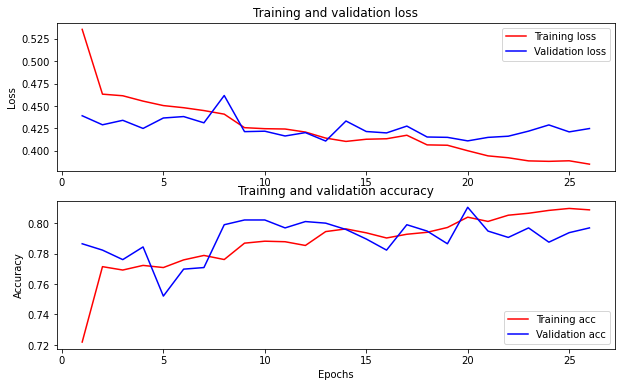

In [23]:
acc = history['binary_accuracy']
val_acc = history['val_binary_accuracy']
loss = history['loss']
val_loss = history['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# <font color="green"> Model Inference

In [2]:
with open("./src/config_6estate.yml") as file:
    config = yaml.safe_load(file)

In [2]:
model = Model(config, "./model")

NameError: name 'config' is not defined

In [129]:
train_dataset, test_dataset, validation_dataset = model.preprocess_data(train, val, test)

In [3]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('./model')  

All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at ./model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


In [195]:
# disable GPU to run bert base as my gpu is out of memory
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

In [5]:
trained_model = TFAutoModelForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=1)  

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
trained_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
_________________________________________________________________
dropout_57 (Dropout)         multiple                  0         
_________________________________________________________________
classifier (Dense)           multiple                  769       
Total params: 109,483,009
Trainable params: 109,483,009
Non-trainable params: 0
_________________________________________________________________


In [12]:
trained_model.trainable

True

In [225]:
predicted_logits = trained_model.predict(test_dataset)["logits"]

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [134]:
predicted_logits

array([[-0.40651459],
       [-1.0602944 ],
       [-0.6155974 ],
       ...,
       [-0.14797056],
       [-0.82446605],
       [ 2.4193926 ]], dtype=float32)

In [139]:
predicted = [int(i) for i in tf.round(tf.sigmoid(predicted_logits)).numpy()]
predicted

[0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,


In [140]:
test["label"].tolist()

[0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,


In [66]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy

In [145]:
m = tf.keras.metrics.BinaryAccuracy()
m.update_state(predicted,test["label"].tolist())
m.result().numpy()

0.8076923

In [147]:
display(f'Fine Tuned BERT Acc: {accuracy_score(predicted, test["label"].tolist()) * 100:.2f}%')

'Fine Tuned BERT Acc: 80.77%'

### plot confusion matrix

In [148]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.xlim(-0.5, len(classes)-0.5)
    plt.ylim(len(np.unique(classes))-0.5, -0.5)
    return ax

Confusion matrix, without normalization
[[439  94]
 [111 422]]


<AxesSubplot:title={'center':'Confusion matrix, without normalization'}, xlabel='Predicted label', ylabel='True label'>

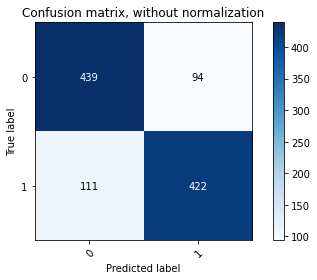

In [149]:
plot_confusion_matrix(test["label"].values, predicted, np.unique(test["label"])) 

In [153]:
recall = recall_score(test["label"].values, predicted)
recall

0.7917448405253283

In [157]:
precision = precision_score(test["label"].values, predicted)
precision

0.8178294573643411

In [152]:
# recall and precision are quite similar to the accuracy